## Stock Market Forecasting

Investment firms, hedge funds and even individuals have been using financial models to better understand market behavior and make profitable investments and trades. A wealth of information is available in the form of historical stock prices and company performance data, suitable for machine learning algorithms to process.
- https://medium.com/@himamohamed9688/stock-market-forecasting-ca11884ceb8c

In [86]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
from pandas_datareader import data as web


matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

We are going to do time series analysis and forecasting for stock market.

In [87]:
df1 = pd.read_csv('Apple.csv')
df2= pd.read_csv('amazon.csv')
df3 = pd.read_csv('TSLA.csv')
stock=df3

In [88]:
stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
1,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
3,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
4,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


In [89]:
stock['Date'].min()

'2010-06-29'

In [90]:
stock['Date'].max()

'2022-03-18'

In [91]:
#stock['Date']=pd.to_datetime(df.Date,format='%Y%m%d', errors='ignore')

In [92]:
stock.Date = pd.to_datetime(stock.Date, format='%Y%m%d', errors='ignore')

## Data preprocessing

This step includes removing columns we do not need, check missing values, aggregate sales by date and so on.

In [93]:
cols = ['High', 'Low', 'Open', 'Volume', 'Adj Close']
stock.drop(cols, axis=1, inplace=True) #needs to be inplace otherwise won't mutate the stock object
stock = stock.sort_values('Date')
type(stock)

pandas.core.frame.DataFrame

In [94]:
stock.isnull().sum()

Date     0
Close    0
dtype: int64

In [95]:
stock

,Date,Close
0,2010-06-29,4.778000
1,2010-06-30,4.766000
2,2010-07-01,4.392000
3,2010-07-02,3.840000
4,2010-07-06,3.222000
...,...,...
2948,2022-03-15,801.890015
2949,2022-03-16,840.229980
2950,2022-03-17,871.599976
2951,2022-03-18,905.390015


In [96]:
stock = stock.groupby('Date')['Close'].sum().reset_index()
stock

,Date,Close
0,2010-06-29,4.778000
1,2010-06-30,4.766000
2,2010-07-01,4.392000
3,2010-07-02,3.840000
4,2010-07-06,3.222000
...,...,...
2947,2022-03-14,766.369995
2948,2022-03-15,801.890015
2949,2022-03-16,840.229980
2950,2022-03-17,871.599976


In [97]:
stock.head()

,Date,Close
0,2010-06-29,4.778
1,2010-06-30,4.766
2,2010-07-01,4.392
3,2010-07-02,3.840
4,2010-07-06,3.222


## Indexing with time series data

In [98]:
stock = stock.set_index('Date')
stock.index


Index(['2010-06-29', '2010-06-30', '2010-07-01', '2010-07-02', '2010-07-06',
       '2010-07-07', '2010-07-08', '2010-07-09', '2010-07-12', '2010-07-13',
       ...
       '2022-03-07', '2022-03-08', '2022-03-09', '2022-03-10', '2022-03-11',
       '2022-03-14', '2022-03-15', '2022-03-16', '2022-03-17', '2022-03-18'],
      dtype='object', name='Date', length=2952)

Our current datetime data can be tricky to work with, therefore, we will use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp.

In [99]:
#y = stock['Close'].resample('M').mean()
stock.index = pd.to_datetime(stock.index)

monthly_mean = stock.Close.resample('M').mean()
monthly_mean

Date
2010-06-30       4.772000
2010-07-31       3.911619
2010-08-31       3.902182
2010-09-30       4.148095
2010-10-31       4.142667
                 ...     
2021-11-30    1120.662383
2021-12-31    1018.889990
2022-01-31    1010.168497
2022-02-28     878.884737
2022-03-31     902.450710
Freq: M, Name: Close, Length: 142, dtype: float64

Have a quick peek 2017 sales data.

In [100]:
monthly_mean['2022':]

Date
2022-01-31    1010.168497
2022-02-28     878.884737
2022-03-31     902.450710
Freq: M, Name: Close, dtype: float64

## Visualizing Close time series data

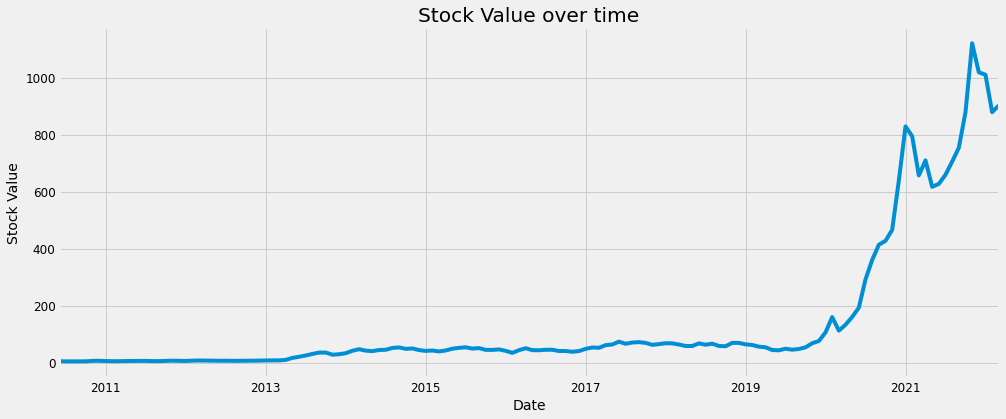

In [102]:
monthly_mean.plot(figsize=(15, 6))
plt.title('Stock Value over time')
plt.xlabel('Date')
plt.ylabel('Stock Value')
plt.show()

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern

We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

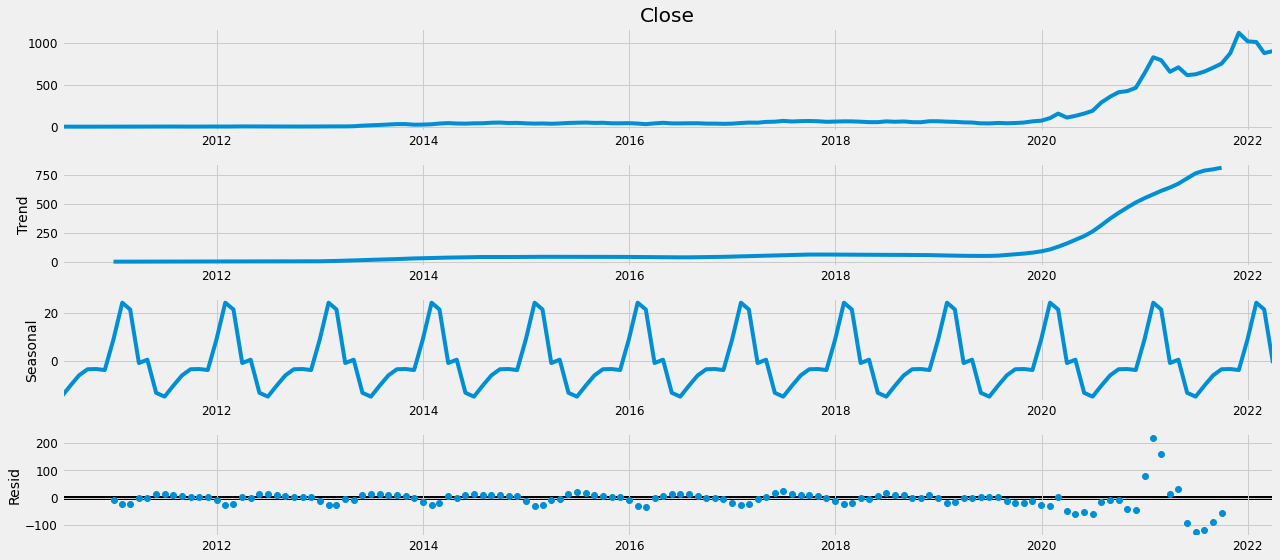

In [103]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(monthly_mean, model='additive')
fig = decomposition.plot()
plt.show()

The plot above clearly shows that the Close price is unstable, along with its obvious seasonality.

## Time series forecasting with ARIMA

We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.

Parameter Selection for the ARIMA Time Series Model. ARIMA models are denoted with the notation `ARIMA(p, d, q)`. These three parameters account for seasonality, trend, and noise in data:

In [104]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
print('pdq =', pdq)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('seasonal_pdq ', seasonal_pdq)

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

pdq = [(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]
seasonal_pdq  [(0, 0, 0, 12), (0, 0, 1, 12), (0, 1, 0, 12), (0, 1, 1, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 1, 0, 12), (1, 1, 1, 12)]
Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [105]:
l_param = []
l_param_seasonal=[]
l_results_aic=[]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(monthly_mean,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            l_param.append(param)
            l_param_seasonal.append(param_seasonal)
            l_results_aic.append(results.aic)
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1999.5673100768145
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1756.059247708452
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1708.0727403085652
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1525.166136508222
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1670.126979705128
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1637.6515256806774
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1539.3259080834764
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1526.9463199616737
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1812.7187117763647
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1585.738498114565
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1539.3797687898436
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1370.8251873783545
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1515.762916248545
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1486.3755371703937
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1397.7192411533654
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1372.8163542002517
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1439.0176217514118
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1328.50931182770

In [106]:
print(l_results_aic)
minimum=l_results_aic[0]
for i in l_results_aic[1:]:
    if i < minimum: 
        minimum = i
i=l_results_aic.index(minimum)

[1999.5673100768145, 1756.059247708452, 1708.0727403085652, 1525.166136508222, 1670.126979705128, 1637.6515256806774, 1539.3259080834764, 1526.9463199616737, 1812.7187117763647, 1585.738498114565, 1539.3797687898436, 1370.8251873783545, 1515.762916248545, 1486.3755371703937, 1397.7192411533654, 1372.8163542002517, 1439.0176217514118, 1328.5093118277098, 1368.294352615798, 1222.22945367675, 1337.797677500632, 1330.4409845795094, 1233.1887266932952, 1223.0097318776839, 1424.995458057916, 1315.4187737147054, 1351.1777085961185, 1210.0647645392614, 1334.027501721719, 1317.3869514632229, 1231.2752950286842, 1210.979619574403, 1445.597792342316, 1336.3678029659754, 1378.2773348933558, 1279.3898603185303, 1336.3667936892284, 1338.3665338589462, 1234.0037903489633, 1237.5128084985345, 1433.6083365143768, 1324.936056278209, 1359.9813343367332, 1268.5567839408454, 1333.9905490461401, 1326.7077900332208, 1232.7338653515826, 1270.556161045874, 1433.3751739440931, 1324.2200346276647, 1364.943871805

In [107]:
mod = sm.tsa.statespace.SARIMAX(monthly_mean,
                                order=l_param[i],
                                seasonal_order=l_param_seasonal[i],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2032      0.070      2.898      0.004       0.066       0.341
ma.S.L12      -0.7319      0.103     -7.116      0.000      -0.933      -0.530
sigma2      1995.3407    131.415     15.183      0.000    1737.771    2252.910


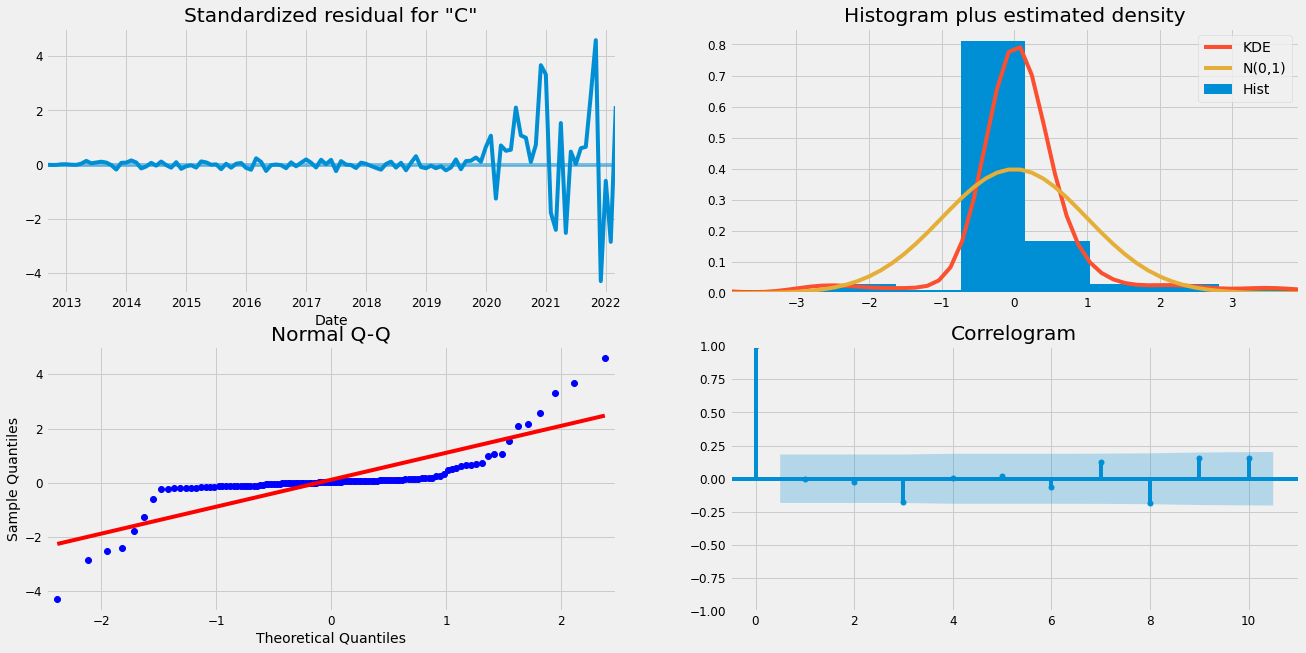

In [108]:
results.plot_diagnostics(figsize=(20, 10))
plt.show()

## Validating forecasts

To help us understand the accuracy of our forecasts, we compare predicted Close to real close price of the time series, and we set forecasts to start at `2017-12-31` to the end of the data.

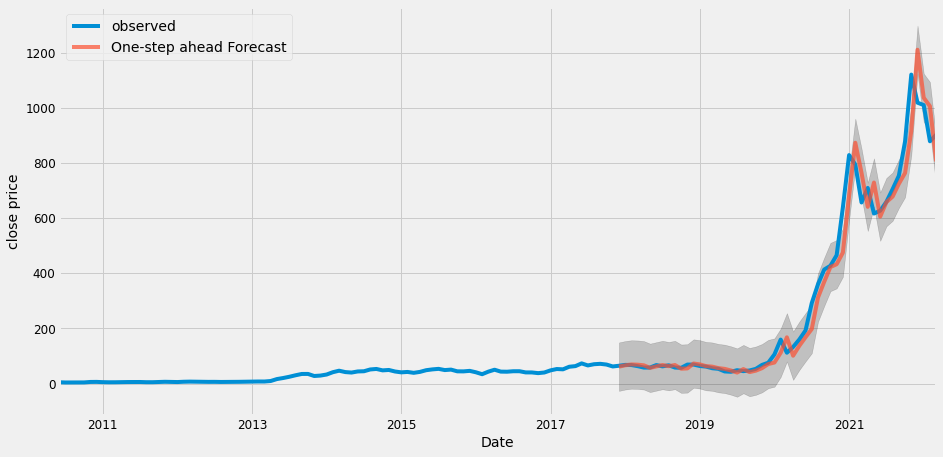

In [110]:
pred = results.get_prediction(start=pd.to_datetime('2017-12-31'), dynamic=False) # prediction start date
pred_ci = pred.conf_int()

ax = monthly_mean['2010':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('close price')
plt.legend()
plt.show()

The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values very well, showing an upward trend starts from the beginning of the year.

In [24]:
y_forecasted = pred.predicted_mean
y_truth = monthly_mean['2017-12-31':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 4388.93


In [25]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 66.25


In statistics, the mean squared error (MSE) of an estimator measures the average of the squares of the errors — that is, the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator—it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit.

Root Mean Square Error (RMSE) tells us that our model was able to forecast the average daily close price in the test set within portion... of the real close price.

## Calculating the Roy Ratio for past
Since the stock prices differ greatly, we cannot just use the absolute value of the mean sqaured error to compare volatility between stocks. Thus, we use something we call the Roy ratio which is equal to the predicted value divided by the volatile range.

In [26]:
actual=pd.DataFrame(monthly_mean['2017-12-31':'2022-03-31'])

result = pd.concat([pred_ci, actual], axis=1).reindex(pred_ci.index)
display(result)

,lower Close,upper Close,Close
Date,,,
2017-12-31,-26.555853,149.064486,64.568201
2018-01-31,-21.584674,154.035665,67.716666
2018-02-28,-18.560382,157.059957,67.155474
2018-03-31,-19.291159,156.329180,63.196666
2018-04-30,-21.578813,154.041526,57.954572
2018-05-31,-30.914901,144.705435,57.970455
2018-06-30,-25.681712,149.938567,67.120095
2018-07-31,-20.553222,155.056888,62.394952
2018-08-31,-24.598205,150.788745,66.242869


In [27]:
diff_result = result.diff()
display(diff_result)

,lower Close,upper Close,Close
Date,,,
2017-12-31,NaN,NaN,NaN
2018-01-31,4.971179,4.971179,3.148466
2018-02-28,3.024292,3.024292,-0.561192
2018-03-31,-0.730777,-0.730777,-3.958808
2018-04-30,-2.287654,-2.287654,-5.242094
2018-05-31,-9.336089,-9.336091,0.015883
2018-06-30,5.233189,5.233132,9.149641
2018-07-31,5.128491,5.118321,-4.725143
2018-08-31,-4.044984,-4.268144,3.847917


In [28]:
print(pred_ci)


            lower Close  upper Close
Date                                
2017-12-31   -26.555853   149.064486
2018-01-31   -21.584674   154.035665
2018-02-28   -18.560382   157.059957
2018-03-31   -19.291159   156.329180
2018-04-30   -21.578813   154.041526
2018-05-31   -30.914901   144.705435
2018-06-30   -25.681712   149.938567
2018-07-31   -20.553222   155.056888
2018-08-31   -24.598205   150.788745
2018-09-30   -20.410589   154.967177
2018-10-31   -33.742940   141.634447
2018-11-30   -32.781775   142.595596
2018-12-31   -14.996120   160.381251
2019-01-31   -18.079656   157.297714
2019-02-28   -24.448569   150.928801
2019-03-31   -26.264057   149.113314
2019-04-30   -31.763875   143.613496
2019-05-31   -34.427342   140.950027
2019-06-30   -40.280080   135.097260
2019-07-31   -47.821490   127.550444
2019-08-31   -35.133281   140.120071
2019-09-30   -46.054035   129.194433
2019-10-31   -40.863905   134.384361
2019-11-30   -31.791004   143.457254
2019-12-31   -16.888442   158.359815
2

In [29]:
roy_ratio=(diff_result['Close'])/(-pred_ci['lower Close']+pred_ci['upper Close'])
roy_ratio # predicted_mean/volatility around mean

Date
2017-12-31         NaN
2018-01-31    0.017928
2018-02-28   -0.003195
2018-03-31   -0.022542
2018-04-30   -0.029849
2018-05-31    0.000090
2018-06-30    0.052099
2018-07-31   -0.026907
2018-08-31    0.021940
2018-09-30   -0.046832
2018-10-31   -0.005879
2018-11-30    0.067856
2018-12-31   -0.000440
2019-01-31   -0.029212
2019-02-28   -0.012277
2019-03-31   -0.034179
2019-04-30   -0.012660
2019-05-31   -0.053531
2019-06-30   -0.006841
2019-07-31    0.032691
2019-08-31   -0.019720
2019-09-30    0.013876
2019-10-31    0.033202
2019-11-30    0.082107
2019-12-31    0.044959
2020-01-31    0.172286
2020-02-29    0.306751
2020-03-31   -0.272009
2020-04-30    0.119256
2020-05-31    0.155011
2020-06-30    0.187296
2020-07-31    0.566747
2020-08-31    0.388347
2020-09-30    0.305033
2020-10-31    0.078287
2020-11-30    0.219221
2020-12-31    0.988736
2021-01-31    1.084364
2021-02-28   -0.196983
2021-03-31   -0.784721
2021-04-30    0.301494
2021-05-31   -0.530114
2021-06-30    0.058035
2021-0

## Producing and visualizing forecasts

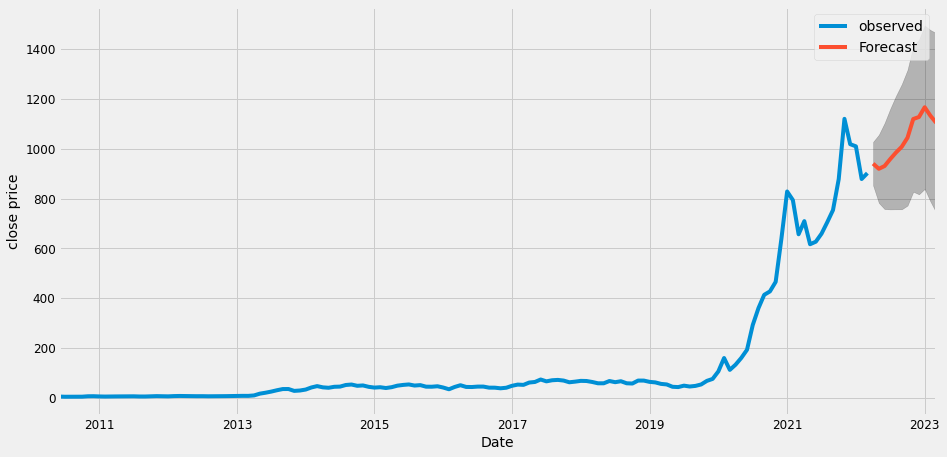

In [30]:
pred_uc = results.get_forecast(steps=12) # each step is 1 month. 12 to predict 1 year
pred_ci = pred_uc.conf_int()

ax = monthly_mean.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('close price')

plt.legend()
plt.show()

Our model clearly captured close price seasonality. As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.

## Calculating roy Ratio for Future allocation

In [31]:
roy_ratio_future_tesla=((pred_ci['upper Close']+pred_ci['lower Close'])/2 )/(pred_ci['upper Close']-pred_ci['lower Close'])
roy_ratio_future_tesla # predicted_mean/volatility around mean



2022-04-30    5.370838
2022-05-31    3.357082
2022-06-30    2.693276
2022-07-31    2.369522
2022-08-31    2.159158
2022-09-30    2.006430
2022-10-31    1.916843
2022-11-30    1.916511
2022-12-31    1.815982
2023-01-31    1.779600
2023-02-28    1.644552
2023-03-31    1.533593
Freq: M, dtype: float64

# Repeating for AAPL

In [32]:
stock2=(web.DataReader("AAPL", data_source='yahoo', start = '2010-06-29', end = '2022-03-18'))['Close']
stock2=pd.DataFrame(stock2)
stock2 = stock2.sort_values('Date')
type(stock2)


stock2.isnull().sum()

stock2

stock2 = stock2.groupby('Date')['Close'].sum().reset_index()
stock2
stock2.head()


,Date,Close
0,2010-06-28,9.582143
1,2010-06-29,9.148929
2,2010-06-30,8.983214
3,2010-07-01,8.874286
4,2010-07-02,8.819286


In [33]:
stock2.Date = pd.to_datetime(stock2.Date, format='%Y%m%d', errors='ignore')

In [34]:
stock2

,Date,Close
0,2010-06-28,9.582143
1,2010-06-29,9.148929
2,2010-06-30,8.983214
3,2010-07-01,8.874286
4,2010-07-02,8.819286
...,...,...
2948,2022-03-14,150.619995
2949,2022-03-15,155.089996
2950,2022-03-16,159.589996
2951,2022-03-17,160.619995


In [35]:
stock2 = stock2.set_index('Date')
stock2.index

DatetimeIndex(['2010-06-28', '2010-06-29', '2010-06-30', '2010-07-01',
               '2010-07-02', '2010-07-06', '2010-07-07', '2010-07-08',
               '2010-07-09', '2010-07-12',
               ...
               '2022-03-07', '2022-03-08', '2022-03-09', '2022-03-10',
               '2022-03-11', '2022-03-14', '2022-03-15', '2022-03-16',
               '2022-03-17', '2022-03-18'],
              dtype='datetime64[ns]', name='Date', length=2953, freq=None)

In [36]:
display(stock2)
stock2.index = pd.to_datetime(stock2.index)

monthly_mean2 = stock2.Close.resample('M').mean()



,Close
Date,
2010-06-28,9.582143
2010-06-29,9.148929
2010-06-30,8.983214
2010-07-01,8.874286
2010-07-02,8.819286
...,...
2022-03-14,150.619995
2022-03-15,155.089996
2022-03-16,159.589996


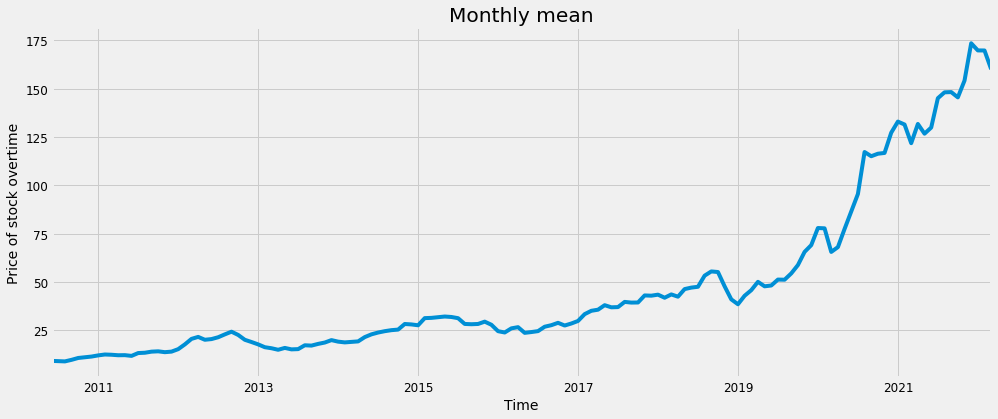

In [82]:
monthly_mean2.plot(figsize=(15, 6))
plt.title('Monthly mean')
plt.xlabel('Time')
plt.ylabel('Price of stock overtime')
plt.show()

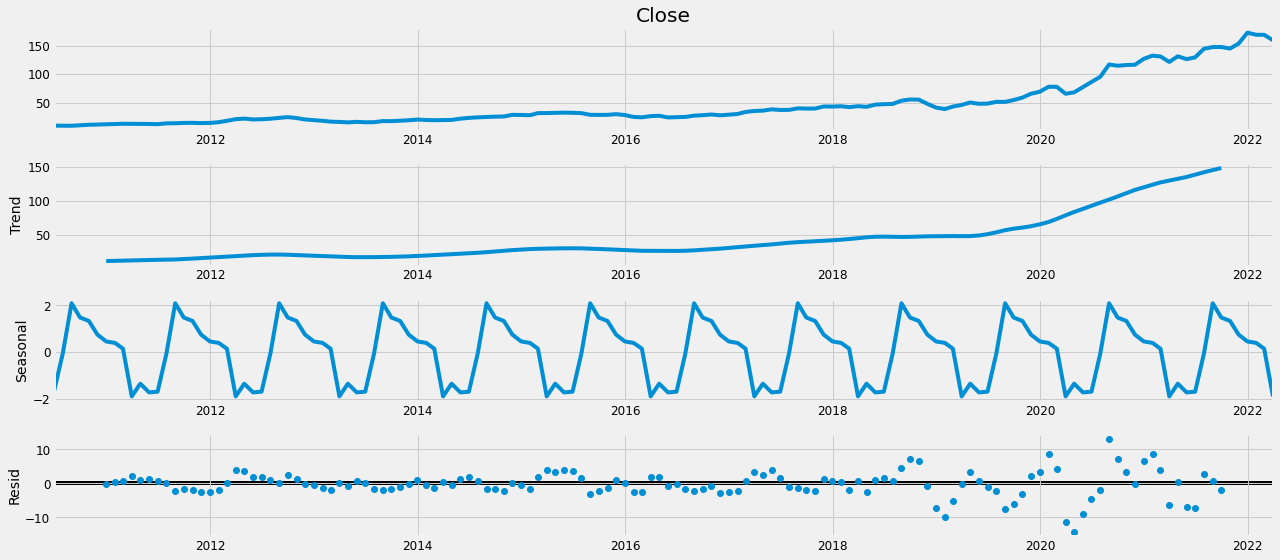

In [38]:
decomposition2 = sm.tsa.seasonal_decompose(monthly_mean2, model='additive')
fig = decomposition2.plot()
plt.show()

In [39]:
l_param = []
l_param_seasonal=[]
l_results_aic=[]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(monthly_mean2,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            l_param.append(param)
            l_param_seasonal.append(param_seasonal)
            l_results_aic.append(results.aic)
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1568.5571161997175
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1336.606478794166
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1166.3614235053599
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1026.8927548820425
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1047.9325238495162
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1033.3296573668022
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1022.5295931072233
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:983.5193195352016
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1379.810695102695
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1170.659220740452
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1011.8434000635445
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:905.9258892443538
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:928.9954234033748
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:904.207008582681
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:910.172642208612
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:869.8658027295979
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:810.2074028511965
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:748.7990340558435
ARIMA

In [40]:
print(l_results_aic)
minimum=l_results_aic[0]
for i in l_results_aic[1:]:
    if i < minimum: 
        minimum = i
i=l_results_aic.index(minimum)

[1568.5571161997175, 1336.606478794166, 1166.3614235053599, 1026.8927548820425, 1047.9325238495162, 1033.3296573668022, 1022.5295931072233, 983.5193195352016, 1379.810695102695, 1170.659220740452, 1011.8434000635445, 905.9258892443538, 928.9954234033748, 904.207008582681, 910.172642208612, 869.8658027295979, 810.2074028511965, 748.7990340558435, 779.149220405656, 685.4561607057943, 750.4181507604264, 745.7789054111217, 684.7134040445293, 681.8069709570804, 799.6250875487035, 741.0102413073515, 774.3452711664786, 680.5795245174078, 748.6342039930919, 739.8111295995445, 684.7072263311103, 676.8579311419725, 802.9460077915935, 746.1430944006152, 785.7984112010984, 690.7472986562386, 745.0118914065974, 746.5032857040678, 685.6184497090434, 687.3500764767756, 797.6912695924506, 741.4042434271465, 780.538330104188, 686.6302030995184, 745.280437116097, 742.0358701777095, 686.1052858952589, 683.0578454362408, 804.2081632141674, 745.7344273354452, 779.4739489412437, 685.8476079046121, 743.75709

In [41]:
mod = sm.tsa.statespace.SARIMAX(monthly_mean2,
                                order=l_param[i],
                                seasonal_order=l_param_seasonal[i],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results2 = mod.fit()

print(results2.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1486      0.077      1.936      0.053      -0.002       0.299
ar.S.L12      -0.6123      0.139     -4.395      0.000      -0.885      -0.339
ma.S.L12      -0.0571      0.155     -0.369      0.712      -0.361       0.246
sigma2        19.6483      1.693     11.604      0.000      16.330      22.967


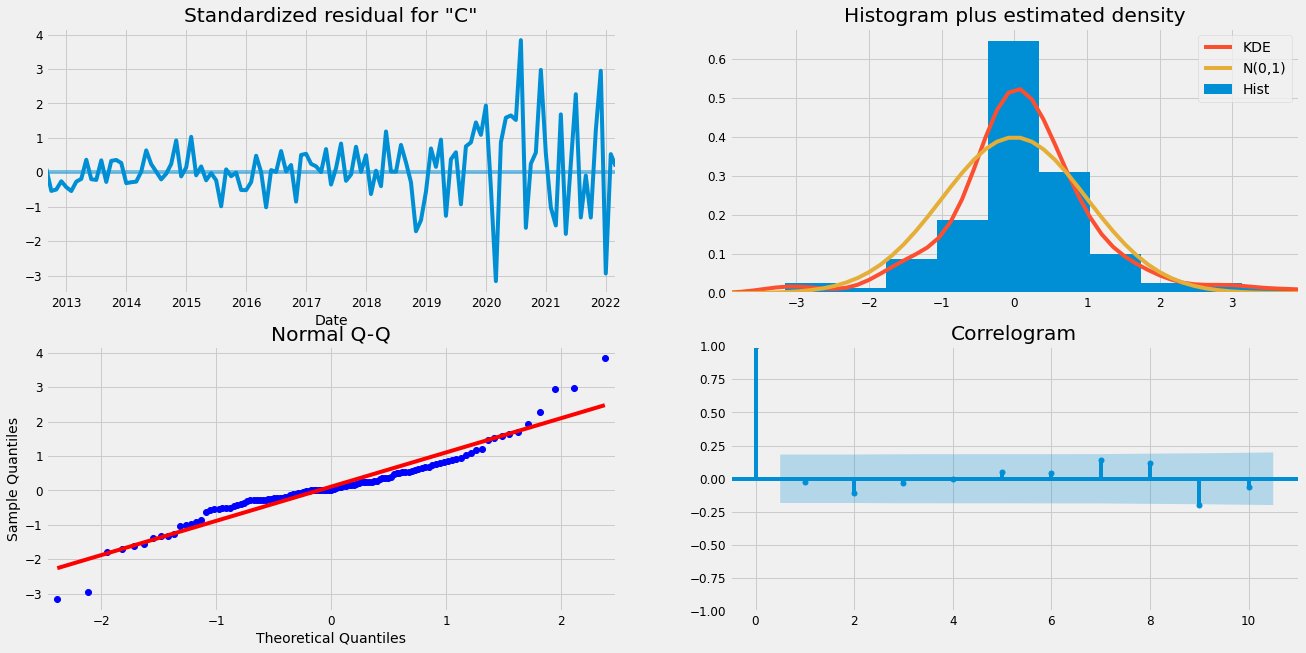

In [42]:
results2.plot_diagnostics(figsize=(20, 10))
plt.show()

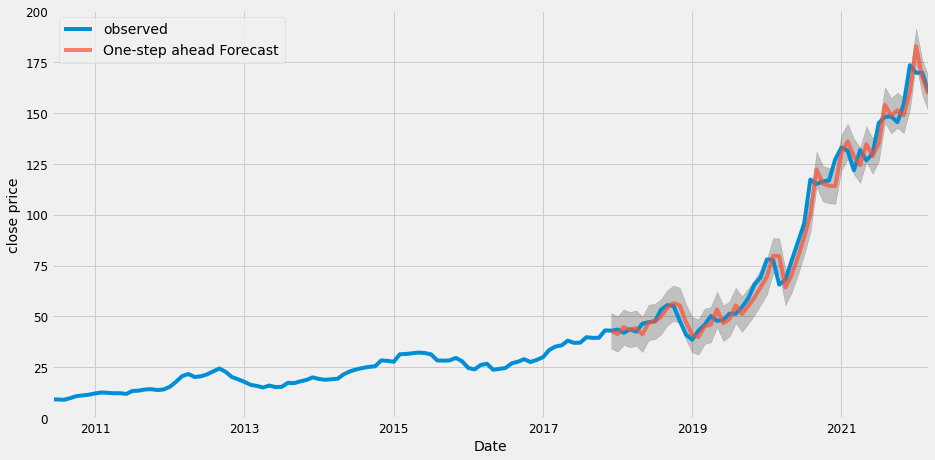

In [43]:
pred2 = results2.get_prediction(start=pd.to_datetime('2017-12-31'), dynamic=False) # prediction start date
pred_ci2 = pred2.conf_int()

ax = monthly_mean2['2010':].plot(label='observed')
pred2.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci2.index,
                pred_ci2.iloc[:, 0],
                pred_ci2.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('close price')
plt.legend()
plt.show()

In [44]:
y_forecasted2 = pred2.predicted_mean
y_truth2 = monthly_mean2['2017-12-31':]

# Compute the mean square error
mse2 = ((y_forecasted2 - y_truth2) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse2, 2)))




The Mean Squared Error of our forecasts is 39.13


In [45]:
roy_calculation2 = pd.DataFrame(y_forecasted2)
roy_calculation2 = pd.concat([roy_calculation2,y_truth2], axis=1).reindex(y_truth2.index)

pred_ci2df = pd.DataFrame(pred_ci2)
roy_calculation2 = pd.concat([roy_calculation2,pred_ci2df], axis=1).reindex(roy_calculation2.index)
display(roy_calculation2)
roy_calculation2['Close']=roy_calculation2['Close'].shift(1)
display(roy_calculation2)

roy_ratio = (roy_calculation2['predicted_mean']-roy_calculation2['Close'])/(roy_calculation2['upper Close']-roy_calculation2['lower Close'])
display(roy_ratio)

,predicted_mean,Close,lower Close,upper Close
Date,,,,
2017-12-31,42.914292,42.972875,34.226471,51.602113
2018-01-31,41.298081,43.501309,32.610261,49.985902
2018-02-28,44.706679,41.909737,36.018858,53.394500
2018-03-31,43.414557,43.624048,34.726736,52.102378
2018-04-30,44.245125,42.458572,35.557304,52.932946
2018-05-31,41.126656,46.384205,32.438835,49.814477
2018-06-30,47.056253,47.155357,38.368432,55.744074
2018-07-31,47.493654,47.577857,38.805833,56.181475
2018-08-31,49.807827,53.336522,41.120006,58.495648


,predicted_mean,Close,lower Close,upper Close
Date,,,,
2017-12-31,42.914292,NaN,34.226471,51.602113
2018-01-31,41.298081,42.972875,32.610261,49.985902
2018-02-28,44.706679,43.501309,36.018858,53.394500
2018-03-31,43.414557,41.909737,34.726736,52.102378
2018-04-30,44.245125,43.624048,35.557304,52.932946
2018-05-31,41.126656,42.458572,32.438835,49.814477
2018-06-30,47.056253,46.384205,38.368432,55.744074
2018-07-31,47.493654,47.155357,38.805833,56.181475
2018-08-31,49.807827,47.577857,41.120006,58.495648


Date
2017-12-31         NaN
2018-01-31   -0.096387
2018-02-28    0.069371
2018-03-31    0.086605
2018-04-30    0.035744
2018-05-31   -0.076654
2018-06-30    0.038678
2018-07-31    0.019470
2018-08-31    0.128339
2018-09-30    0.052194
2018-10-31    0.056272
2018-11-30    0.010814
2018-12-31   -0.032736
2019-01-31   -0.002158
2019-02-28    0.075943
2019-03-31    0.126007
2019-04-30    0.005759
2019-05-31    0.189431
2019-06-30   -0.072322
2019-07-31    0.027596
2019-08-31    0.233387
2019-09-30   -0.004907
2019-10-31    0.027189
2019-11-30    0.021862
2019-12-31   -0.076000
2020-01-31    0.014706
2020-02-29    0.106467
2020-03-31    0.103921
2020-04-30   -0.078988
2020-05-31    0.136132
2020-06-30    0.093994
2020-07-31    0.136506
2020-08-31    0.271428
2020-09-30    0.286143
2020-10-31    0.010235
2020-11-30   -0.122463
2020-12-31   -0.156738
2021-01-31    0.190601
2021-02-28    0.174346
2021-03-31   -0.162195
2021-04-30    0.142839
2021-05-31    0.167087
2021-06-30    0.119416
2021-0

# Combining stocks and predictions
### After successfully prediction the price of stocks - AAPL and TSLA - we create a function, get_ratio that fits an arima model and predicts the value for each month. 

In [79]:
def get_ratio(name):
    stock2=(web.DataReader(name, data_source='yahoo', start = '2010-06-29', end = '2022-03-18'))['Close']
    stock2=pd.DataFrame(stock2)
    stock2 = stock2.sort_values('Date')
    type(stock2)


    stock2.isnull().sum()

    

    stock2 = stock2.groupby('Date')['Close'].sum().reset_index()
    stock2
    stock2.head()

    stock2.Date = pd.to_datetime(stock2.Date, format='%Y%m%d', errors='ignore')
    stock2 = stock2.set_index('Date')
    stock2.index = pd.to_datetime(stock2.index)

    monthly_mean2 = stock2.Close.resample('M').mean()
    decomposition2 = sm.tsa.seasonal_decompose(monthly_mean2, model='additive')
    l_param = []
    l_param_seasonal=[]
    l_results_aic=[]
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(monthly_mean2,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

                results = mod.fit()

            
                l_param.append(param)
                l_param_seasonal.append(param_seasonal)
                l_results_aic.append(results.aic)
            except:
                continue
    minimum=l_results_aic[0]
    for i in l_results_aic[1:]:
        if i < minimum: 
            minimum = i
    i=l_results_aic.index(minimum)
    mod = sm.tsa.statespace.SARIMAX(monthly_mean2,
                                order=l_param[i],
                                seasonal_order=l_param_seasonal[i],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results2 = mod.fit()
    pred2 = results2.get_prediction(start=pd.to_datetime('2017-12-31'), dynamic=False) # prediction start date

    #ax = monthly_mean2['2010':].plot(label='observed')
    #pred2.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    y_forecasted2 = pred2.predicted_mean
    y_truth2 = monthly_mean2['2017-12-31':]

    # Compute the mean square error
    mse2 = ((y_forecasted2 - y_truth2) ** 2).mean()
    actual2=pd.DataFrame(monthly_mean2['2017-12-31':'2022-03-31'])

    roy_calculation2 = pd.DataFrame(y_forecasted2)
    roy_calculation2 = pd.concat([roy_calculation2,y_truth2], axis=1).reindex(y_truth2.index)

    pred_ci2df = pd.DataFrame(pred_ci2)
    roy_calculation2 = pd.concat([roy_calculation2,pred_ci2df], axis=1).reindex(roy_calculation2.index)
    roy_calculation2['Close']=roy_calculation2['Close'].shift(1)

    roy_ratio = (roy_calculation2['predicted_mean']-roy_calculation2['Close'])/(roy_calculation2['upper Close']-roy_calculation2['lower Close'])

     # predicted_mean/range of prediction=((upper+lower)/2)/upper-lower

    return roy_ratio, pd.DataFrame(y_truth2)

In [80]:
stock_list=["AAPL", "CAH", "CMCSA", "DISH", "GOOG", "HSY", "JNJ", "JPM", "K", "MA", "NFLX", "UL", "WBA"]
everything = pd.DataFrame()
prices = pd.DataFrame()
for ns in stock_list:
    temp1, temp2 = get_ratio(ns)
    everything = pd.concat([everything, temp1], axis=1).reindex(temp1.index)
    prices = pd.concat([prices, temp2], axis=1).reindex(temp2.index)
    everything.rename(columns={'0': ns}, inplace=True)

everything.columns = ["AAPL", "CAH", "CMCSA", "DISH", "GOOG", "HSY", "JNJ", "JPM", "K", "MA", "NFLX", "UL", "WBA"]
prices.columns = ["AAPL", "CAH", "CMCSA", "DISH", "GOOG", "HSY", "JNJ", "JPM", "K", "MA", "NFLX", "UL", "WBA"]
display(everything,prices)

/Users/lakshya/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lakshya/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lakshya/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lakshya/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/lakshya/opt/anaconda3/lib/python3.8/s

,AAPL,CAH,CMCSA,DISH,GOOG,HSY,JNJ,JPM,K,MA,NFLX,UL,WBA
Date,,,,,,,,,,,,,
2017-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-31,-0.096387,0.041053,0.001818,-0.014403,0.058535,0.156606,-0.117773,-0.101551,0.041122,-0.382251,-0.178754,-0.022715,0.005487
2018-02-28,0.069371,0.092752,0.054363,0.005464,1.772180,0.078370,-0.078557,0.075388,0.041149,-0.036265,1.448187,0.077648,0.136946
2018-03-31,0.086605,0.075770,0.012725,0.045839,-0.231691,-0.080959,0.151082,0.134977,0.048564,0.204377,0.814637,0.040273,0.015839
2018-04-30,0.035744,-0.052789,-0.011816,-0.070323,-0.070725,0.010529,0.128707,0.028089,0.050178,0.158584,1.031712,0.081809,0.016794
2018-05-31,-0.076654,-0.080737,-0.021165,0.025191,0.873146,-0.038217,0.169755,0.003926,-0.102646,0.030423,-0.036137,0.012016,-0.073725
2018-06-30,0.038678,0.047698,0.004153,0.033687,0.557752,-0.009129,0.209285,0.052269,-0.021084,-0.049199,0.709926,0.000222,0.008191
2018-07-31,0.019470,0.064588,0.116382,0.063566,1.732740,0.110732,0.267221,-0.032944,0.112338,-0.051620,1.561035,0.051324,0.047379
2018-08-31,0.128339,-0.134644,-0.059807,-0.125483,0.894944,-0.021211,0.050039,0.030887,0.037561,0.135871,-0.189082,-0.035104,-0.080718


,AAPL,CAH,CMCSA,DISH,GOOG,HSY,JNJ,JPM,K,MA,NFLX,UL,WBA
Date,,,,,,,,,,,,,
2017-12-31,42.972875,61.220000,39.466000,49.111000,1043.653003,113.787001,140.895999,106.279000,66.899000,150.442499,187.854501,55.772000,71.923001
2018-01-31,43.501309,70.193334,41.827142,47.744286,1130.770467,110.687618,143.656666,112.354285,67.392859,163.215714,232.908096,55.807619,75.851904
2018-02-28,41.909737,67.784209,39.200526,44.488947,1088.206839,99.508421,131.465264,114.003158,67.338421,171.526840,271.443683,53.399473,70.273157
2018-03-31,43.624048,67.747619,35.378095,39.676667,1091.490479,99.372381,130.017619,113.397143,66.902381,178.087144,312.228097,52.989524,68.113810
2018-04-30,42.458572,62.906190,33.443333,37.843333,1035.696187,95.732380,128.539048,110.422857,62.476667,174.810477,307.466192,55.568571,64.856190
2018-05-31,46.384205,54.150454,31.800454,31.761818,1069.275901,91.807727,123.520454,110.885455,61.402728,190.262727,331.536819,55.302273,63.845454
2018-06-30,47.155357,53.168571,32.542381,32.846191,1137.626668,92.270952,122.277619,107.734762,66.259047,198.808571,384.133336,54.814285,64.451905
2018-07-31,47.577857,49.739523,34.162857,32.239047,1187.590472,94.075715,127.281905,109.951905,70.530476,203.889047,381.515238,55.848095,64.980000
2018-08-31,53.336522,50.834783,35.656957,35.065218,1225.671732,99.316956,133.094783,115.584783,71.812174,205.468696,346.257824,56.765217,68.254348


In [49]:
display(everything)
display(prices)

,AAPL,CAH,CMCSA,DISH,GOOG,HSY,JNJ,JPM,K,MA,NFLX,UL,WBA
Date,,,,,,,,,,,,,
2017-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-31,-0.096387,0.041053,0.001818,-0.014403,0.058535,0.156606,-0.117773,-0.101551,0.041122,-0.382251,-0.178754,-0.022715,0.005487
2018-02-28,0.069371,0.092752,0.054363,0.005464,1.772180,0.078370,-0.078557,0.075388,0.041149,-0.036265,1.448187,0.077648,0.136946
2018-03-31,0.086605,0.075770,0.012725,0.045839,-0.231691,-0.080959,0.151082,0.134977,0.048564,0.204377,0.814637,0.040273,0.015839
2018-04-30,0.035744,-0.052789,-0.011816,-0.070323,-0.070725,0.010529,0.128707,0.028089,0.050178,0.158584,1.031712,0.081809,0.016794
2018-05-31,-0.076654,-0.080737,-0.021165,0.025191,0.873146,-0.038217,0.169755,0.003926,-0.102646,0.030423,-0.036137,0.012016,-0.073725
2018-06-30,0.038678,0.047698,0.004153,0.033687,0.557752,-0.009129,0.209285,0.052269,-0.021084,-0.049199,0.709926,0.000222,0.008191
2018-07-31,0.019470,0.064588,0.116382,0.063566,1.732740,0.110732,0.267221,-0.032944,0.112338,-0.051620,1.561035,0.051324,0.047379
2018-08-31,0.128339,-0.134644,-0.059807,-0.125483,0.894944,-0.021211,0.050039,0.030887,0.037561,0.135871,-0.189082,-0.035104,-0.080718


,AAPL,CAH,CMCSA,DISH,GOOG,HSY,JNJ,JPM,K,MA,NFLX,UL,WBA
Date,,,,,,,,,,,,,
2017-12-31,42.972875,61.220000,39.466000,49.111000,1043.653003,113.787001,140.895999,106.279000,66.899000,150.442499,187.854501,55.772000,71.923001
2018-01-31,43.501309,70.193334,41.827142,47.744286,1130.770467,110.687618,143.656666,112.354285,67.392859,163.215714,232.908096,55.807619,75.851904
2018-02-28,41.909737,67.784209,39.200526,44.488947,1088.206839,99.508421,131.465264,114.003158,67.338421,171.526840,271.443683,53.399473,70.273157
2018-03-31,43.624048,67.747619,35.378095,39.676667,1091.490479,99.372381,130.017619,113.397143,66.902381,178.087144,312.228097,52.989524,68.113810
2018-04-30,42.458572,62.906190,33.443333,37.843333,1035.696187,95.732380,128.539048,110.422857,62.476667,174.810477,307.466192,55.568571,64.856190
2018-05-31,46.384205,54.150454,31.800454,31.761818,1069.275901,91.807727,123.520454,110.885455,61.402728,190.262727,331.536819,55.302273,63.845454
2018-06-30,47.155357,53.168571,32.542381,32.846191,1137.626668,92.270952,122.277619,107.734762,66.259047,198.808571,384.133336,54.814285,64.451905
2018-07-31,47.577857,49.739523,34.162857,32.239047,1187.590472,94.075715,127.281905,109.951905,70.530476,203.889047,381.515238,55.848095,64.980000
2018-08-31,53.336522,50.834783,35.656957,35.065218,1225.671732,99.316956,133.094783,115.584783,71.812174,205.468696,346.257824,56.765217,68.254348


In [50]:
everything_copy = pd.DataFrame()
everything_copy = pd.concat([everything_copy, everything], axis=1).reindex(everything.index)

In [51]:

for i,row in everything_copy.iterrows():
    sum = 0
    print(i)
    stockNames = []
    for index, value in row.iteritems():
        if value>0:
            sum+=value
            print(index, value)
            stockNames.append(index)
    print(stockNames)
    print('Sum: ', sum, '\n')
    
    for stock in stockNames:
        stockPercentage = row[stock]/sum * 100
        print(stock, 'value:', stockPercentage)
        # !: mutates the everthing dataframe, and takes a long time to re-run the code above so be careful
        everything_copy.at[i, stock] = stockPercentage
        
        

    print('\n')
    
    

2017-12-31 00:00:00
[]
Sum:  0 



2018-01-31 00:00:00
CAH 0.04105315499625329
CMCSA 0.0018180225349612696
GOOG 0.058534712980334726
HSY 0.15660619129843517
K 0.04112218921591731
WBA 0.0054870985426466986
['CAH', 'CMCSA', 'GOOG', 'HSY', 'K', 'WBA']
Sum:  0.30462136956854846 

CAH value: 13.476781046056969
CMCSA value: 0.5968138537149354
GOOG value: 19.215563590709532
HSY value: 51.410113322070906
K value: 13.499443349677295
WBA value: 1.8012848377703672


2018-02-28 00:00:00
AAPL 0.06937121089372146
CAH 0.0927517730871479
CMCSA 0.0543628248023445
DISH 0.005463946487184473
GOOG 1.7721803860512513
HSY 0.07837018509915114
JPM 0.07538792193208504
K 0.04114852132026423
NFLX 1.4481869833518903
UL 0.07764771849981336
WBA 0.13694628249045993
['AAPL', 'CAH', 'CMCSA', 'DISH', 'GOOG', 'HSY', 'JPM', 'K', 'NFLX', 'UL', 'WBA']
Sum:  3.8518177540153133 

AAPL value: 1.800999302768302
CAH value: 2.408000040771897
CMCSA value: 1.4113550607547352
DISH value: 0.14185371261370303
GOOG value: 46.0089365392

K 0.0071157222314262945
MA 0.9289842916954665
WBA 0.046957303552572494
['AAPL', 'CAH', 'CMCSA', 'GOOG', 'HSY', 'JNJ', 'K', 'MA', 'WBA']
Sum:  3.541889189141841 

AAPL value: 15.170567609496189
CAH value: 1.773236616991389
CMCSA value: 1.7356833342240314
GOOG value: 48.9835070199583
HSY value: 3.810652342101527
JNJ value: 0.7711844374765022
K value: 0.2009018874232582
MA value: 26.2284967735128
WBA value: 1.3257699788160144


2022-02-28 00:00:00
CAH 0.08482182440758039
DISH 0.022490590387202598
GOOG 2.5965931745016695
HSY 0.16155945175353578
K 0.030569086469169
MA 0.7696875688253604
UL 0.05343455420339278
WBA 0.04042058896429955
['CAH', 'DISH', 'GOOG', 'HSY', 'K', 'MA', 'UL', 'WBA']
Sum:  3.75957683951221 

CAH value: 2.2561534988758387
DISH value: 0.5982213250925511
GOOG value: 69.06610199350432
HSY value: 4.2972775567608155
K value: 0.813099127218137
MA value: 20.472718119128118
UL value: 1.421291716711546
WBA value: 1.075136662708667


2022-03-31 00:00:00
CAH 0.0009152443912136181
HS

In [52]:
for i, row in everything_copy.iterrows():
    for index, value in row.iteritems():
        if value<0:
            # print(i, index)
            everything_copy.at[i, index] = 0

## This represents the portfolio percentages at each point in time
- From here, we will calculate the portfolio returns if we rebalance at the end of every month
- If all the cells in a row are 0, then the entire portfolio will be converted to cash for that month and reallocted in other stocks by the indicated percentages. If all stocks are allocated as 0, no investment is made for that time period.

In [53]:
prices

,AAPL,CAH,CMCSA,DISH,GOOG,HSY,JNJ,JPM,K,MA,NFLX,UL,WBA
Date,,,,,,,,,,,,,
2017-12-31,42.972875,61.220000,39.466000,49.111000,1043.653003,113.787001,140.895999,106.279000,66.899000,150.442499,187.854501,55.772000,71.923001
2018-01-31,43.501309,70.193334,41.827142,47.744286,1130.770467,110.687618,143.656666,112.354285,67.392859,163.215714,232.908096,55.807619,75.851904
2018-02-28,41.909737,67.784209,39.200526,44.488947,1088.206839,99.508421,131.465264,114.003158,67.338421,171.526840,271.443683,53.399473,70.273157
2018-03-31,43.624048,67.747619,35.378095,39.676667,1091.490479,99.372381,130.017619,113.397143,66.902381,178.087144,312.228097,52.989524,68.113810
2018-04-30,42.458572,62.906190,33.443333,37.843333,1035.696187,95.732380,128.539048,110.422857,62.476667,174.810477,307.466192,55.568571,64.856190
2018-05-31,46.384205,54.150454,31.800454,31.761818,1069.275901,91.807727,123.520454,110.885455,61.402728,190.262727,331.536819,55.302273,63.845454
2018-06-30,47.155357,53.168571,32.542381,32.846191,1137.626668,92.270952,122.277619,107.734762,66.259047,198.808571,384.133336,54.814285,64.451905
2018-07-31,47.577857,49.739523,34.162857,32.239047,1187.590472,94.075715,127.281905,109.951905,70.530476,203.889047,381.515238,55.848095,64.980000
2018-08-31,53.336522,50.834783,35.656957,35.065218,1225.671732,99.316956,133.094783,115.584783,71.812174,205.468696,346.257824,56.765217,68.254348


In [54]:
everything_copy

,AAPL,CAH,CMCSA,DISH,GOOG,HSY,JNJ,JPM,K,MA,NFLX,UL,WBA
Date,,,,,,,,,,,,,
2017-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-31,0.000000,13.476781,0.596814,0.000000,19.215564,51.410113,0.000000,0.000000,13.499443,0.000000,0.000000,0.000000,1.801285
2018-02-28,1.800999,2.408000,1.411355,0.141854,46.008937,2.034629,0.000000,1.957204,1.068288,0.000000,37.597495,2.015872,3.555368
2018-03-31,5.310956,4.646497,0.780344,2.811003,0.000000,0.000000,9.264914,8.277300,2.978140,12.533193,49.956631,2.469712,0.971310
2018-04-30,2.317817,0.000000,0.000000,0.000000,0.000000,0.682761,8.345953,1.821403,3.253781,10.283318,66.901051,5.304906,1.089009
2018-05-31,0.000000,0.000000,0.000000,2.260408,78.347198,0.000000,15.232078,0.352272,0.000000,2.729833,0.000000,1.078210,0.000000
2018-06-30,2.327369,2.870137,0.249877,2.027087,33.561920,0.000000,12.593401,3.145188,0.000000,0.000000,42.718747,0.013379,0.492894
2018-07-31,0.469512,1.557538,2.806571,1.532893,41.785243,2.670324,6.444068,0.000000,2.709053,0.000000,37.644564,1.237690,1.142545
2018-08-31,10.044980,0.000000,0.000000,0.000000,70.046590,0.000000,3.916539,2.417526,2.939860,10.634506,0.000000,0.000000,0.000000


In [55]:

relevantPrices = prices[prices.index.isin(everything_copy.index)]
relevantPrices


,AAPL,CAH,CMCSA,DISH,GOOG,HSY,JNJ,JPM,K,MA,NFLX,UL,WBA
Date,,,,,,,,,,,,,
2017-12-31,42.972875,61.220000,39.466000,49.111000,1043.653003,113.787001,140.895999,106.279000,66.899000,150.442499,187.854501,55.772000,71.923001
2018-01-31,43.501309,70.193334,41.827142,47.744286,1130.770467,110.687618,143.656666,112.354285,67.392859,163.215714,232.908096,55.807619,75.851904
2018-02-28,41.909737,67.784209,39.200526,44.488947,1088.206839,99.508421,131.465264,114.003158,67.338421,171.526840,271.443683,53.399473,70.273157
2018-03-31,43.624048,67.747619,35.378095,39.676667,1091.490479,99.372381,130.017619,113.397143,66.902381,178.087144,312.228097,52.989524,68.113810
2018-04-30,42.458572,62.906190,33.443333,37.843333,1035.696187,95.732380,128.539048,110.422857,62.476667,174.810477,307.466192,55.568571,64.856190
2018-05-31,46.384205,54.150454,31.800454,31.761818,1069.275901,91.807727,123.520454,110.885455,61.402728,190.262727,331.536819,55.302273,63.845454
2018-06-30,47.155357,53.168571,32.542381,32.846191,1137.626668,92.270952,122.277619,107.734762,66.259047,198.808571,384.133336,54.814285,64.451905
2018-07-31,47.577857,49.739523,34.162857,32.239047,1187.590472,94.075715,127.281905,109.951905,70.530476,203.889047,381.515238,55.848095,64.980000
2018-08-31,53.336522,50.834783,35.656957,35.065218,1225.671732,99.316956,133.094783,115.584783,71.812174,205.468696,346.257824,56.765217,68.254348


In [56]:
dates = relevantPrices.index
indexes = [i for i in range(52)]
relevantPrices['indexNum'] = indexes
relevantPrices = relevantPrices.set_index('indexNum')
portfolioDailyChange = relevantPrices

aaplDailyChange = [0]
cahDailyChange = [0]
cmcsaDailyChange = [0]
dishDailyChange = [0]
googDailyChange = [0]
hsyDailyChange = [0]
jnjDailyChange = [0]
jpmDailyChange = [0]
kDailyChange = [0]
maDailyChange = [0]
nflxDailyChange = [0]
ulDailyChange = [0]
wbaDailyChange = [0]

for index, row in portfolioDailyChange.iterrows():
    if index==portfolioDailyChange.index[0]:
        continue
    previousVal = portfolioDailyChange.iloc[[index-1]]['AAPL']
    percentageChange = (row['AAPL'] - previousVal)/previousVal*100
    aaplDailyChange.append(float(percentageChange))
    
    previousVal = portfolioDailyChange.iloc[[index-1]]['CAH']
    percentageChange = (row['CAH'] - previousVal)/previousVal*100
    cahDailyChange.append(float(percentageChange))

    previousVal = portfolioDailyChange.iloc[[index-1]]['CMCSA']
    percentageChange = (row['CMCSA'] - previousVal)/previousVal*100
    cmcsaDailyChange.append(float(percentageChange))


    previousVal = portfolioDailyChange.iloc[[index-1]]['DISH']
    percentageChange = (row['DISH'] - previousVal)/previousVal*100
    dishDailyChange.append(float(percentageChange))


    previousVal = portfolioDailyChange.iloc[[index-1]]['GOOG']
    percentageChange = (row['GOOG'] - previousVal)/previousVal*100
    googDailyChange.append(float(percentageChange))

    previousVal = portfolioDailyChange.iloc[[index-1]]['HSY']
    percentageChange = (row['HSY'] - previousVal)/previousVal*100
    hsyDailyChange.append(float(percentageChange))

    previousVal = portfolioDailyChange.iloc[[index-1]]['JNJ']
    percentageChange = (row['JNJ'] - previousVal)/previousVal*100
    jnjDailyChange.append(float(percentageChange))


    previousVal = portfolioDailyChange.iloc[[index-1]]['JPM']
    percentageChange = (row['JPM'] - previousVal)/previousVal*100
    jpmDailyChange.append(float(percentageChange))


    previousVal = portfolioDailyChange.iloc[[index-1]]['K']
    percentageChange = (row['K'] - previousVal)/previousVal*100
    kDailyChange.append(float(percentageChange))


    previousVal = portfolioDailyChange.iloc[[index-1]]['MA']
    percentageChange = (row['MA'] - previousVal)/previousVal*100
    maDailyChange.append(float(percentageChange))


    previousVal = portfolioDailyChange.iloc[[index-1]]['NFLX']
    percentageChange = (row['NFLX'] - previousVal)/previousVal*100
    nflxDailyChange.append(float(percentageChange))


    previousVal = portfolioDailyChange.iloc[[index-1]]['UL']
    percentageChange = (row['UL'] - previousVal)/previousVal*100
    ulDailyChange.append(float(percentageChange))

    
    previousVal = portfolioDailyChange.iloc[[index-1]]['WBA']
    percentageChange = (row['WBA'] - previousVal)/previousVal*100
    wbaDailyChange.append(float(percentageChange))



# print(float(aaplDailyChange[1]))
portfolioDailyChange['AAPLPercentageChange'] = aaplDailyChange
portfolioDailyChange['CAHPercentageChange'] = cahDailyChange
portfolioDailyChange['CMCSAPercentageChange'] = cmcsaDailyChange
portfolioDailyChange['DISHPercentageChange'] = dishDailyChange
portfolioDailyChange['GOOGPercentageChange'] = googDailyChange
portfolioDailyChange['HSYPercentageChange'] = hsyDailyChange
portfolioDailyChange['JNJPercentageChange'] = jnjDailyChange
portfolioDailyChange['JPMPercentageChange'] = jpmDailyChange
portfolioDailyChange['KPercentageChange'] = kDailyChange
portfolioDailyChange['MAPercentageChange'] = maDailyChange
portfolioDailyChange['NFLXPercentageChange'] = nflxDailyChange
portfolioDailyChange['ULPercentageChange'] = ulDailyChange
portfolioDailyChange['WBAPercentageChange'] = wbaDailyChange


portfolioDailyChange = portfolioDailyChange.drop(columns=['AAPL', 'CAH', 'CMCSA', 'DISH', 'GOOG', 'HSY', 'JNJ', 'JPM', 'K', 'MA', 'NFLX', 'UL', 'WBA'])
portfolioDailyChange['date'] = dates
portfolioDailyChange = portfolioDailyChange.set_index('date')
portfolioDailyChange

,AAPLPercentageChange,CAHPercentageChange,CMCSAPercentageChange,DISHPercentageChange,GOOGPercentageChange,HSYPercentageChange,JNJPercentageChange,JPMPercentageChange,KPercentageChange,MAPercentageChange,NFLXPercentageChange,ULPercentageChange,WBAPercentageChange
date,,,,,,,,,,,,,
2017-12-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-01-31,1.229693,14.657521,5.982726,-2.782908,8.347359,-2.723846,1.959365,5.716354,0.738215,8.490430,23.983240,0.063865,5.462652
2018-02-28,-3.658677,-3.432127,-6.279693,-6.818279,-3.764126,-10.099772,-8.486485,1.467566,-0.080777,5.092111,16.545405,-4.315084,-7.354788
2018-03-31,4.090484,-0.053981,-9.750969,-10.816800,0.301748,-0.136712,-1.101161,-0.531578,-0.647534,3.824651,15.025000,-0.767703,-3.072791
2018-04-30,-2.671637,-7.146272,-5.468813,-4.620685,-5.111752,-3.662990,-1.137208,-2.622893,-6.615182,-1.839923,-1.525137,4.867089,-4.782613
2018-05-31,9.245796,-13.918719,-4.912426,-16.070241,3.242236,-4.099609,-3.904334,0.418933,-1.718944,8.839430,7.828707,-0.479225,-1.558426
2018-06-30,1.662533,-1.813250,2.333071,3.414076,6.392248,0.504561,-1.006178,-2.841394,7.908964,4.491602,15.864457,-0.882400,0.949874
2018-07-31,0.895975,-6.449389,4.979585,-1.848444,4.391933,1.955938,4.092561,2.057964,6.446559,2.555461,-0.681559,1.886023,0.819363
2018-08-31,12.103666,2.201990,4.373463,8.766296,3.206599,5.571301,4.566932,5.123039,1.817226,0.774759,-9.241417,1.642172,5.039009


In [85]:
portfolioDailyChange #Percentage for reallocation

,AAPLPercentageChange,CAHPercentageChange,CMCSAPercentageChange,DISHPercentageChange,GOOGPercentageChange,HSYPercentageChange,JNJPercentageChange,JPMPercentageChange,KPercentageChange,MAPercentageChange,NFLXPercentageChange,ULPercentageChange,WBAPercentageChange
date,,,,,,,,,,,,,
2017-12-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-01-31,1.229693,14.657521,5.982726,-2.782908,8.347359,-2.723846,1.959365,5.716354,0.738215,8.490430,23.983240,0.063865,5.462652
2018-02-28,-3.658677,-3.432127,-6.279693,-6.818279,-3.764126,-10.099772,-8.486485,1.467566,-0.080777,5.092111,16.545405,-4.315084,-7.354788
2018-03-31,4.090484,-0.053981,-9.750969,-10.816800,0.301748,-0.136712,-1.101161,-0.531578,-0.647534,3.824651,15.025000,-0.767703,-3.072791
2018-04-30,-2.671637,-7.146272,-5.468813,-4.620685,-5.111752,-3.662990,-1.137208,-2.622893,-6.615182,-1.839923,-1.525137,4.867089,-4.782613
2018-05-31,9.245796,-13.918719,-4.912426,-16.070241,3.242236,-4.099609,-3.904334,0.418933,-1.718944,8.839430,7.828707,-0.479225,-1.558426
2018-06-30,1.662533,-1.813250,2.333071,3.414076,6.392248,0.504561,-1.006178,-2.841394,7.908964,4.491602,15.864457,-0.882400,0.949874
2018-07-31,0.895975,-6.449389,4.979585,-1.848444,4.391933,1.955938,4.092561,2.057964,6.446559,2.555461,-0.681559,1.886023,0.819363
2018-08-31,12.103666,2.201990,4.373463,8.766296,3.206599,5.571301,4.566932,5.123039,1.817226,0.774759,-9.241417,1.642172,5.039009


In [58]:
everything_copy

,AAPL,CAH,CMCSA,DISH,GOOG,HSY,JNJ,JPM,K,MA,NFLX,UL,WBA
Date,,,,,,,,,,,,,
2017-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-31,0.000000,13.476781,0.596814,0.000000,19.215564,51.410113,0.000000,0.000000,13.499443,0.000000,0.000000,0.000000,1.801285
2018-02-28,1.800999,2.408000,1.411355,0.141854,46.008937,2.034629,0.000000,1.957204,1.068288,0.000000,37.597495,2.015872,3.555368
2018-03-31,5.310956,4.646497,0.780344,2.811003,0.000000,0.000000,9.264914,8.277300,2.978140,12.533193,49.956631,2.469712,0.971310
2018-04-30,2.317817,0.000000,0.000000,0.000000,0.000000,0.682761,8.345953,1.821403,3.253781,10.283318,66.901051,5.304906,1.089009
2018-05-31,0.000000,0.000000,0.000000,2.260408,78.347198,0.000000,15.232078,0.352272,0.000000,2.729833,0.000000,1.078210,0.000000
2018-06-30,2.327369,2.870137,0.249877,2.027087,33.561920,0.000000,12.593401,3.145188,0.000000,0.000000,42.718747,0.013379,0.492894
2018-07-31,0.469512,1.557538,2.806571,1.532893,41.785243,2.670324,6.444068,0.000000,2.709053,0.000000,37.644564,1.237690,1.142545
2018-08-31,10.044980,0.000000,0.000000,0.000000,70.046590,0.000000,3.916539,2.417526,2.939860,10.634506,0.000000,0.000000,0.000000


In [84]:
# everything_copy.loc['2018-01-31']

# for index, row in portfolioDailyChange.iterrows():
#     print(index)
#     print(everything_copy.loc[index]['AAPL'])
#     print()

In [76]:
portfolioChangesArr = []

for index, row in portfolioDailyChange.iterrows():
  if index==0:
    continue
  portfolioChange = row['AAPLPercentageChange'] * everything_copy.loc[index]['AAPL'] + row['CAHPercentageChange'] * everything_copy.loc[index]['CAH'] +  row['CMCSAPercentageChange'] * everything_copy.loc[index]['CMCSA'] +  row['DISHPercentageChange'] * everything_copy.loc[index]['DISH'] +  row['GOOGPercentageChange'] * everything_copy.loc[index]['GOOG'] +  row['HSYPercentageChange'] * everything_copy.loc[index]['HSY'] +  row['JNJPercentageChange'] * everything_copy.loc[index]['JNJ'] +  row['JPMPercentageChange'] * everything_copy.loc[index]['JPM'] +  row['KPercentageChange'] * everything_copy.loc[index]['K'] +  row['MAPercentageChange'] * everything_copy.loc[index]['MA'] +  row['NFLXPercentageChange'] * everything_copy.loc[index]['NFLX'] +  row['ULPercentageChange'] * everything_copy.loc[index]['UL'] +  row['WBAPercentageChange'] * everything_copy.loc[index]['WBA']
  
  portfolioChangesArr.append(portfolioChange/100)
    # print(row['AAPLPercentageChange'])
    


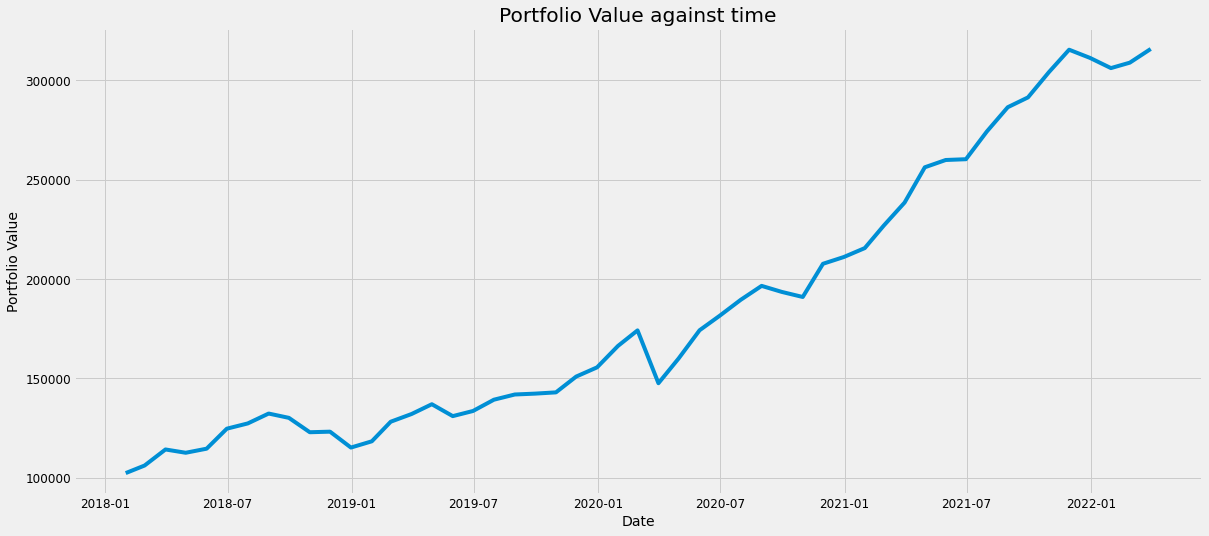

In [83]:
cumulativeChange = 1* 100000
portfolioValuesArr = []
for i in portfolioChangesArr[1:]:
    cumulativeChange *= 1 + (i/100)
    portfolioValuesArr.append(cumulativeChange)
    
y = portfolioValuesArr 
x = everything_copy.index[1:]

plt.title('Portfolio Value against time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.plot(x,y)

TODO:
- use the stock prices to get the monthly return corresponding to the everything table
- use the algorithm in control.ipynb to calculate the total portfolio return for each month
- compound everything and get the total return and sharpe ratio over the whole timeframe